In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

In [3]:
def plot_lightcurve(tus, start=None, stop=None):
  # Convert trigger times from seconds to minutes
     
    if start and stop != None:
        # Create a histogram of the trigger times
        plt.hist(tus, bins=100, range=(start, stop))
    else:
        plt.hist(tus, bins=100)
    # Set the x-axis label
    plt.xlabel('Time (s)')

    # Set the y-axis label
    plt.ylabel('Number of triggers')

    # Show the plot
    plt.show()

# Notes
    - The main burst in ASIM seems to be highly correlated with the first peak in FERMI data
    - tlagg = 1.79s
    - spectral analysis for T0+5.9s to T0+6.5s

# harvest data

dau/det starting from index 1
tus array given in seconds
safety time:  6.241 % removed
sorted by tus (s)


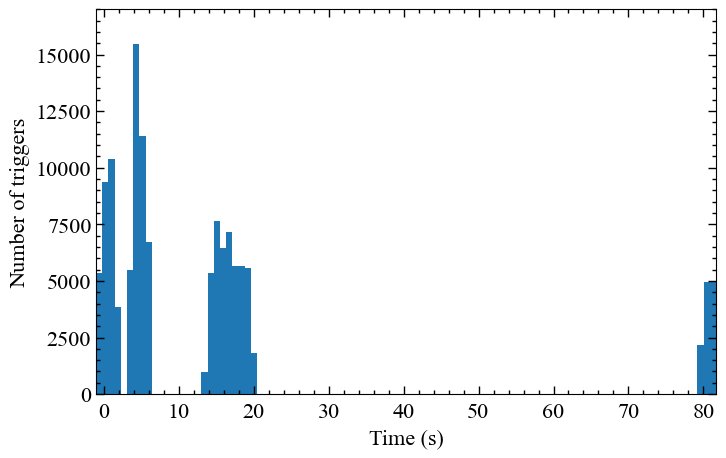

In [10]:
df = harvest_data(fn='2021_12_11_13_10_1',T0='2021-12-11T13:10:01.323')
df.sort_values(by='tus',inplace=True,ignore_index=True)
tus = df['tus'].to_numpy()
T0 = datetime.fromisoformat('2021-12-11T13:10:01.323')
plot_lightcurve(tus=tus)

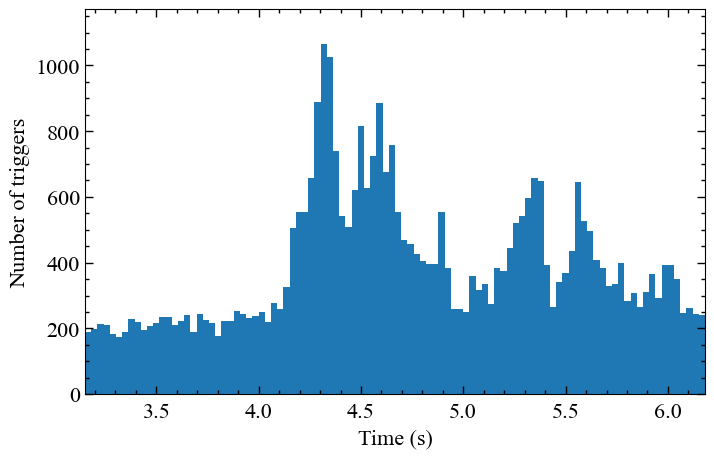

In [89]:
i_start, j_end = find_nearest(tus,3),find_nearest(tus,7)
tus_burst = tus[i_start:j_end+1]
plot_lightcurve(tus=tus_burst)

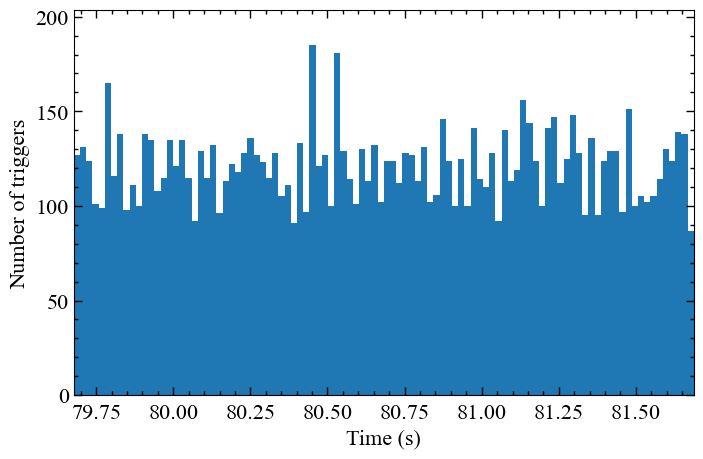

In [16]:
tus_bkg = tus[j_end+1:]
plot_lightcurve(tus=tus_bkg)

## fermi data

In [25]:
GRB_id = "GRB211211A"
bn='bn211211549' #what is this? GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit
trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)

# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 212.271, 27.883  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


glg_trigdat_all_bn211211549_v01.fit
660921004.65092
['n2', 'na']
n2 28.936
na 49.853
n1 73.267
n5 75.59
b0 78.593
n9 84.886
n0 94.495
b1 101.407
nb 104.726
n3 128.519
n6 128.828
n4 130.308
n7 145.304
n8 149.746


In [30]:
unit = all_dets[idx_sort_angsep][4] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v02.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

b0


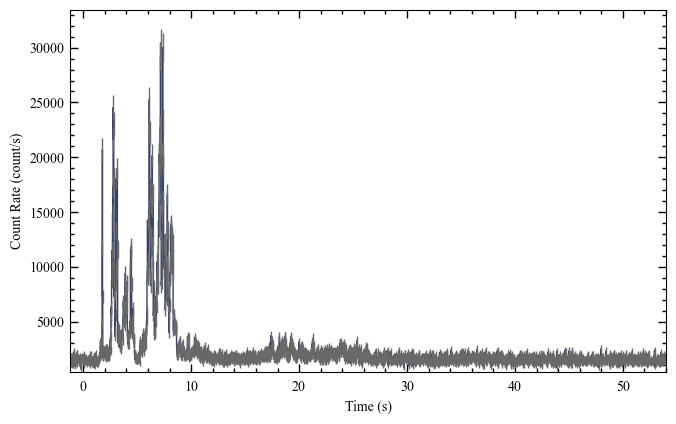

In [90]:
# open a TTE file
tte = TTE.open(fn_tte)
# bin to 2.048 s resolution, reference time is trigger time (coarse resolution to accurately model the bkg)
bint = 0.02 # 4ms binning
#phaii = tte.to_phaii(bin_by_time, bint, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, bint,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,1e5) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-1.264,54.033)

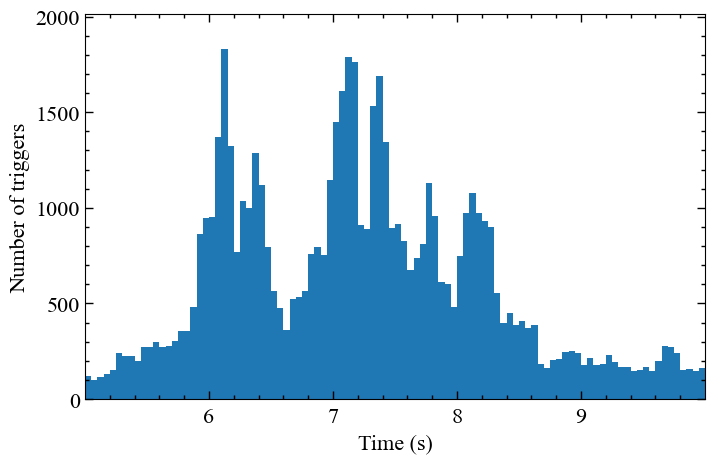

In [91]:
tus_fermi = tte.data.time
ix,jx = find_nearest(tus_fermi,5), find_nearest(tus_fermi,10)
tus_fermi = tus_fermi[ix:jx]
plot_lightcurve(tus_fermi)

# cross correlation

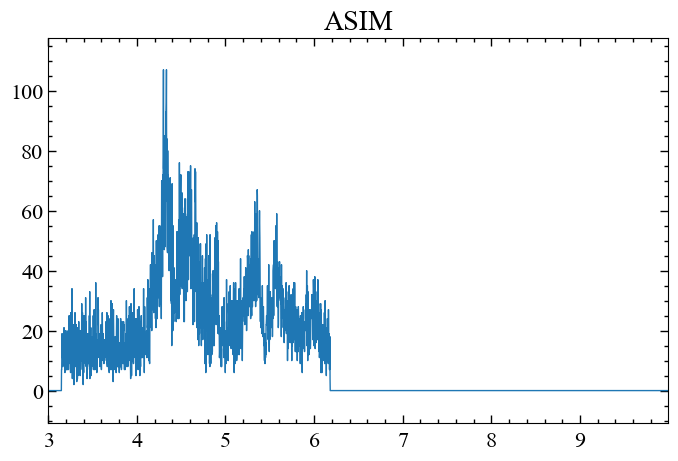

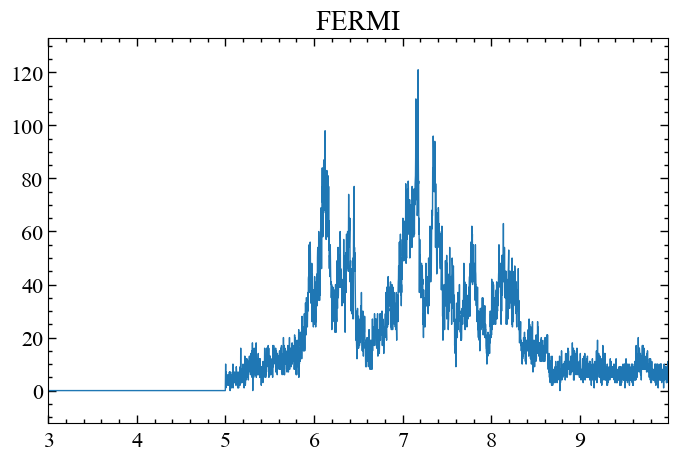

In [93]:
binsize = 0.002
bins = np.arange(3,10,binsize)

asim_hist = np.histogram(tus_burst,bins=bins)
asim_counts,asim_edges = asim_hist[0],asim_hist[1]

asim_lc = LC(time=asim_edges[:-1],counts=asim_counts,dt=binsize)
asim_lc.plot(title='ASIM')

fermi_hist = np.histogram(tus_fermi,bins=bins)
fermi_counts,fermi_edges = fermi_hist[0],fermi_hist[1]
fermi_lc = LC(time=fermi_edges[:-1],counts=fermi_counts,dt=binsize)
fermi_lc.plot(title='FERMI')

Total lagg (s):  1.79


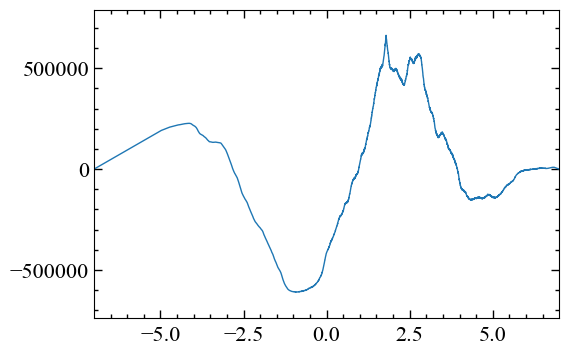

<AxesSubplot:>

In [94]:
cc = CC(fermi_lc,asim_lc,mode="full")
tlagg=cc.time_shift
print("Total lagg (s): ", tlagg)
cc.plot()

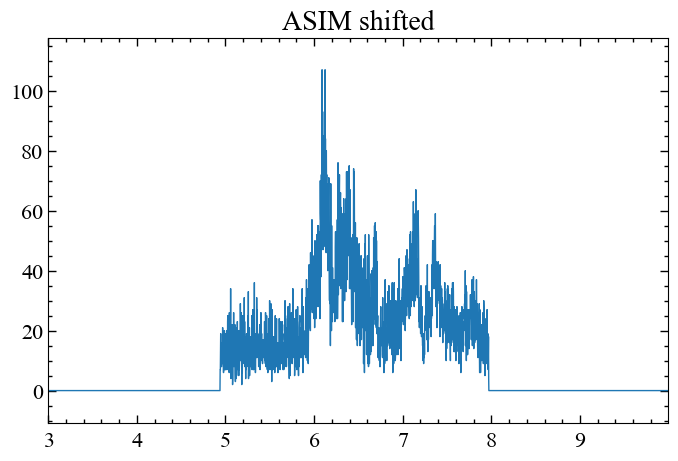

In [95]:
tus_burst_shift = tus_burst + tlagg
asim_hist_shift = np.histogram(tus_burst_shift,bins=bins)
asim_counts_shift,asim_edges_shift = asim_hist_shift[0],asim_hist_shift[1]

asim_lc_shift = LC(time=asim_edges_shift[:-1],counts=asim_counts_shift,dt=binsize)
asim_lc_shift.plot(title='ASIM shifted')

### cc results

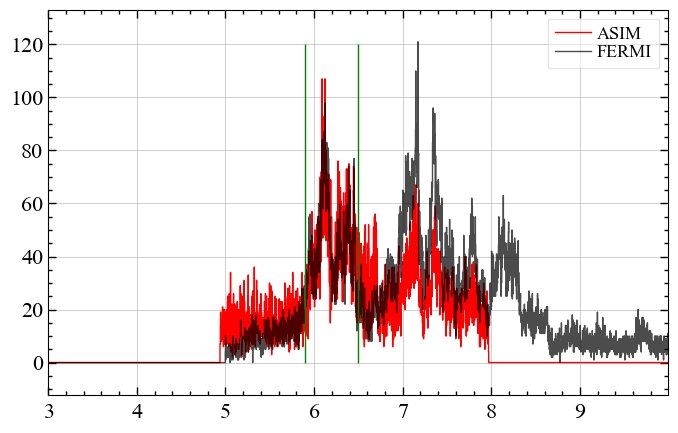

In [106]:
plt.step(x=asim_edges_shift[:-1],y=asim_counts_shift,label='ASIM',color='red')
plt.step(x=fermi_edges[:-1],y=fermi_counts,label='FERMI',color='black',alpha=0.7)
plt.vlines(x=5.9,ymin=0,ymax=120,color='g')
plt.vlines(x=6.5,ymin=0,ymax=120,color='g')
plt.legend()
plt.grid()
plt.show()

# Extraction of FITS files

## ASIM extraction

In [124]:
#harvesting new dataframe and shifting by tlagg
df = harvest_data(fn='2021_12_11_13_10_1',T0='2021-12-11T13:10:01.323')
df.sort_values(by='tus',inplace=True,ignore_index=True)

tlagg=1.79 #s

T0 = datetime.fromisoformat('2021-12-11T13:10:01.323')+timedelta(seconds=tlagg)
tus = df['tus'].to_numpy() + tlagg
df['tus'] = tus

dau/det starting from index 1
tus array given in seconds
safety time:  6.241 % removed
sorted by tus (s)


In [ ]:
i_start,i_end = find_nearest(tus,5.9),find_nearest(tus,6.5)
tus_burst = tus[i_start:i_end]
plot_HED(tus_arr=tus_burst*1e6,binsize=2,T0=T0)

In [126]:
df_burst = df.truncate(before=i_start,after=i_end)
#plot_HED(tus_arr=df_burst['tus'].to_numpy()*1e6,binsize=2,T0=T0) #same interval

In [127]:
df_keV = keV_hist(df=df_burst,time_interval='max',keV_interval='max',convert_seconds=False)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  13342
n triggers are within bounds  13342
keV bins are set for HED
Energies binned!


In [136]:
bin_lo = df_keV['bins_keV'].to_numpy()[:-1]
bin_hi = df_keV['bins_keV'].to_numpy()[1:]
counts = df_keV['counts'].to_numpy()[1:]
err = df_keV['poisson_error_counts'].to_numpy()[1:]
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [134]:
print('Exposure: ',np.round(tus_burst[-1]-tus_burst[0],3))
print(T0)

Exposure:  0.6
2021-12-11 13:10:03.113000


In [141]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [5.90,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [6.50,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.6,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB211211A.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB211211A.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB211211A.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [142]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK
    T0+80s background accumulation

In [ ]:
tus_bkg = df['tus'].to_numpy()
i_bkg_start = find_nearest(tus_bkg,80)
plot_lightcurve(tus=tus_bkg[i_bkg_start:])
df_bkg = df.truncate(before=i_bkg_start)
df_bkg

In [ ]:
df_kev_bkg = keV_hist(df_bkg,time_interval='max',keV_interval='max',convert_seconds=False)
df_kev_bkg

In [152]:
print('Exposure bkg',np.round(tus_bkg[i_bkg_start:][-1]-tus_bkg[i_bkg_start:][0],3))
print('start',round(tus_bkg[i_bkg_start:][0],3))
print('end',round(tus_bkg[i_bkg_start:][-1],3))

Exposure bkg 2.01
start 81.468
end 83.478


In [153]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [81.468,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [83.478,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [2.01,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB211211A.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [154]:
bak_counts = df_kev_bkg['counts'].to_numpy()[1:]
bak_err = df_kev_bkg['poisson_error_counts'].to_numpy()[1:]

generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP

In [155]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [5.90,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [6.50,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.60,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB211211A.rsp','RSP filename'] #<str>  ('example.pha')
}

In [156]:
theta,phi = 112.775,-177.757
drm_path = '/Home/siv30/wad005/master/HED_DRM/data'
drmfname = find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
print(drmfname)

HED_drm_mats_120.00_-180.00.txt


In [157]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=theta,phi=phi)

## FERMI extraction

In [114]:
tus_fermi = tus_fermi[find_nearest(tus_fermi,5.9):find_nearest(tus_fermi,6.5)]

In [116]:
len(tus_burst),len(tus_fermi) #decent agreement

(13342, 13288)